In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.7
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 0.0158

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 530ms/step - loss: 0.0104
Average validation loss: 0.6698557734489441
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 541ms/step - loss: 0.0104 - val_loss: 0.6699
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 627ms/step - loss: 0.0065 - val_loss: 0.6699
Average validation loss: 0.5941259860992432
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 641ms/step - loss: 0.0065 - val_loss: 0.6320
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 805ms/step - loss: 0.0046 - val_loss: 0.6320
Average validation loss: 0.5466113686561584
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 818ms/step - loss: 0.0046 - val_loss: 0.6035
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 774ms/step - loss: 4.6813e-06
Average validation loss: 0.590486690402031
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 785ms/step - loss: 4.6813e-06 - val_loss: 0.5905
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 778ms/step - loss: 4.7860e-06 - val_loss: 0.5905
Average validation loss: 0.30726099014282227
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 791ms/step - loss: 4.7860e-06 - val_loss: 0.4489
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 781ms/step - loss: 4.7149e-06 - val_loss: 0.4489
Average validation loss: 0.19293725490570068
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 795ms/step - loss: 4.7149e-06 - val_loss: 0.3636
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 773ms/step - loss: 2.7992e-06
Average validation loss: 0.06760781072080135
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 785ms/step - loss: 2.7992e-06 - val_loss: 0.0676
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 771ms/step - loss: 2.5858e-06 - val_loss: 0.0676
Average validation loss: 0.08634541307886441
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 782ms/step - loss: 2.5858e-06 - val_loss: 0.0770
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 777ms/step - loss: 2.4522e-06 - val_loss: 0.0770
Average validation loss: 0.1062031090259552
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 789ms/step - loss: 2.4522e-06 - val_loss: 0.0867
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 774ms/step - loss: 2.3239e-06 - val_loss: 0.0867
Average validation loss: 0.1178488830725352
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 785ms/step - loss: 2.3239e-06 - val_loss: 0.0945
Epoch 5/10
12

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 792ms/step - loss: 6.7746e-07
Average validation loss: 0.02890790579840541
16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 803ms/step - loss: 6.7746e-07 - val_loss: 0.0289
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 780ms/step - loss: 6.3617e-07 - val_loss: 0.0289
Average validation loss: 0.03306681045796722
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 790ms/step - loss: 6.3617e-07 - val_loss: 0.0310
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 791ms/step - loss: 5.8269e-07 - val_loss: 0.0310
Average validation loss: 0.039229469606652856
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 801ms/step - loss: 5.8269e-07 - val_loss: 0.0337
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 775ms/step - loss: 5.5636e-07 - val_loss: 0.0337
Average validation loss: 0.02236945170443505
16/16 ━━━━━━━━━━━━━━━━━━━━ 51s 785ms/step - loss: 5.5636e-07 - val_loss: 0.0309
Saved mo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 784ms/step - loss: 4.3872e-07
Average validation loss: 0.027108802739530802
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 794ms/step - loss: 4.3872e-07 - val_loss: 0.0271
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 781ms/step - loss: 4.2220e-07 - val_loss: 0.0271
Average validation loss: 0.033341987244784835
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 792ms/step - loss: 4.2220e-07 - val_loss: 0.0302
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 782ms/step - loss: 3.8460e-07 - val_loss: 0.0302
Average validation loss: 0.02069390220567584
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 792ms/step - loss: 3.8460e-07 - val_loss: 0.0270
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_25.pth'.
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 815ms/step - loss: 3.515

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 831ms/step - loss: 4.8396e-07
Average validation loss: 0.0227472911356017
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 840ms/step - loss: 4.8396e-07 - val_loss: 0.0227
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 783ms/step - loss: 4.3491e-07 - val_loss: 0.0227
Average validation loss: 0.01602035268054654
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 791ms/step - loss: 4.3491e-07 - val_loss: 0.0194
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 790ms/step - loss: 3.6474e-07 - val_loss: 0.0194
Average validation loss: 0.015353602706454694
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 801ms/step - loss: 3.6474e-07 - val_loss: 0.0180
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\wei

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 729ms/step - loss: 5.2256e-07
Average validation loss: 0.0339180295704864
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 740ms/step - loss: 5.2256e-07 - val_loss: 0.0339
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 61s 787ms/step - loss: 4.4078e-07 - val_loss: 0.0339
Average validation loss: 0.04050405188463628
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 797ms/step - loss: 4.4078e-07 - val_loss: 0.0372
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 92s 750ms/step - loss: 3.6800e-07 - val_loss: 0.0372
Average validation loss: 0.02287922406103462
40/40 ━━━━━━━━━━━━━━━━━━━━ 92s 759ms/step - loss: 3.6800e-07 - val_loss: 0.0324
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_50.pth'.
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 123s 782ms/step - loss: 3.2715e

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 39s 812ms/step - loss: 3.1430e-07
Average validation loss: 0.021827348304213956
48/48 ━━━━━━━━━━━━━━━━━━━━ 40s 824ms/step - loss: 3.1430e-07 - val_loss: 0.0218
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 817ms/step - loss: 2.3282e-07 - val_loss: 0.0218
Average validation loss: 0.01302320031390991
48/48 ━━━━━━━━━━━━━━━━━━━━ 79s 829ms/step - loss: 2.3282e-07 - val_loss: 0.0174
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 817ms/step - loss: 1.8409e-07 - val_loss: 0.0174
Average validation loss: 0.014936825735882545
48/48 ━━━━━━━━━━━━━━━━━━━━ 119s 829ms/step - loss: 1.8409e-07 - val_loss: 0.0166
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 158s 806ms/step - loss: 1.

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 793ms/step - loss: 1.5630e-07
Average validation loss: 0.016873303135590895
56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 804ms/step - loss: 1.5630e-07 - val_loss: 0.0169
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 867ms/step - loss: 1.1658e-07 - val_loss: 0.0169
Average validation loss: 0.014508732528026615
56/56 ━━━━━━━━━━━━━━━━━━━━ 94s 878ms/step - loss: 1.1658e-07 - val_loss: 0.0157
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 138s 787ms/step - loss: 9.5534e-08 - val_loss: 0.0157
Average validation loss: 0.01635205383146448
56/56 ━━━━━━━━━━━━━━━━━━━━ 139s 798ms/step - loss: 9.5534e-08 - val_loss: 0.0159
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 183s 790ms/step - loss: 8.

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 781ms/step - loss: 1.1707e-07
Average validation loss: 0.02059477468719706
64/64 ━━━━━━━━━━━━━━━━━━━━ 51s 792ms/step - loss: 1.1707e-07 - val_loss: 0.0206
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 783ms/step - loss: 9.7493e-08 - val_loss: 0.0206
Average validation loss: 0.0170741772162728
64/64 ━━━━━━━━━━━━━━━━━━━━ 102s 794ms/step - loss: 9.7493e-08 - val_loss: 0.0188
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 784ms/step - loss: 8.6024e-08 - val_loss: 0.0188
Average validation loss: 0.01333525899099186
64/64 ━━━━━━━━━━━━━━━━━━━━ 152s 795ms/step - loss: 8.6024e-08 - val_loss: 0.0170
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 777ms/step - loss: 7.5315e-08
Average validation loss: 0.019834580171542864
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 788ms/step - loss: 7.5315e-08 - val_loss: 0.0198
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 789ms/step - loss: 5.9870e-08 - val_loss: 0.0198
Average validation loss: 0.03371340434467937
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 800ms/step - loss: 5.9870e-08 - val_loss: 0.0268
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 171s 784ms/step - loss: 5.2376e-08 - val_loss: 0.0268
Average validation loss: 0.025319003377161507
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 795ms/step - loss: 5.2376e-08 - val_loss: 0.0263
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 228s 777ms/step - loss: 4.9090e-08 - val_loss: 0.0263
Average validation loss: 0.03798299173811554
72/72 ━━━━━━━━━━━━━━━━━━━━ 228s 787ms/step - loss: 4.9090e-08 - val_loss: 0.0292
E

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 786ms/step - loss: 6.5873e-08
Average validation loss: 0.015712607075693087
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 797ms/step - loss: 6.5873e-08 - val_loss: 0.0157
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 128s 805ms/step - loss: 5.3320e-08 - val_loss: 0.0157
Average validation loss: 0.02100141723640263
80/80 ━━━━━━━━━━━━━━━━━━━━ 129s 815ms/step - loss: 5.3320e-08 - val_loss: 0.0184
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 198s 854ms/step - loss: 4.6743e-08 - val_loss: 0.0184
Average validation loss: 0.015408463723724708
80/80 ━━━━━━━━━━━━━━━━━━━━ 199s 865ms/step - loss: 4.6743e-08 - val_loss: 0.0174
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_100.pth'.
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 267s 859ms/step - loss

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 88s 912ms/step - loss: 1.0413e-07
Average validation loss: 0.018311845982680097
96/96 ━━━━━━━━━━━━━━━━━━━━ 89s 923ms/step - loss: 1.0413e-07 - val_loss: 0.0183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 165s 799ms/step - loss: 7.9727e-08 - val_loss: 0.0183
Average validation loss: 0.027904637487760436
96/96 ━━━━━━━━━━━━━━━━━━━━ 166s 810ms/step - loss: 7.9727e-08 - val_loss: 0.0231
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 242s 789ms/step - loss: 6.5513e-08 - val_loss: 0.0231
Average validation loss: 0.02733362712509309
96/96 ━━━━━━━━━━━━━━━━━━━━ 243s 799ms/step - loss: 6.5513e-08 - val_loss: 0.0245
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 320s 802ms/step - loss: 5.8258e-08 - val_loss: 0.0245
Average validation loss: 0.02352792380649286
96/96 ━━━━━━━━━━━━━━━━━━━━ 321s 813ms/step - loss: 5.8258e-08 - val_loss: 0.0243


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 97s 806ms/step - loss: 2.6421e-07
Average validation loss: 0.024264332908205687
120/120 ━━━━━━━━━━━━━━━━━━━━ 98s 817ms/step - loss: 2.6421e-07 - val_loss: 0.0243
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 195s 804ms/step - loss: 1.8922e-07 - val_loss: 0.0243
Average validation loss: 0.03131138429356118
120/120 ━━━━━━━━━━━━━━━━━━━━ 196s 815ms/step - loss: 1.8922e-07 - val_loss: 0.0278
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 781ms/step - loss: 1.8085e-07 - val_loss: 0.0278
Average validation loss: 0.022120859714535375
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 792ms/step - loss: 1.8085e-07 - val_loss: 0.0259
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_150.pth'.
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 385s 786

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 782ms/step - loss: 2.2352e-07
Average validation loss: 0.027190531203005876
144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 792ms/step - loss: 2.2352e-07 - val_loss: 0.0272
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 227s 785ms/step - loss: 1.7280e-07 - val_loss: 0.0272
Average validation loss: 0.02558847824952358
144/144 ━━━━━━━━━━━━━━━━━━━━ 229s 796ms/step - loss: 1.7280e-07 - val_loss: 0.0264
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_180.pth'.
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 341s 781ms/step - loss: 1.4122e-07 - val_loss: 0.0264
Average validation loss: 0.026618454676483654
144/144 ━━━━━━━━━━━━━━━━━━━━ 343s 791ms/step - loss: 1.4122e-07 - val_loss: 0.0265
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 458s 8

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 778ms/step - loss: 8.2837e-08
Average validation loss: 0.012708480874425731
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 789ms/step - loss: 8.2837e-08 - val_loss: 0.0127
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 774ms/step - loss: 6.7750e-08 - val_loss: 0.0127
Average validation loss: 0.021661876057623885
160/160 ━━━━━━━━━━━━━━━━━━━━ 252s 785ms/step - loss: 6.7750e-08 - val_loss: 0.0172
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 377s 781ms/step - loss: 5.8395e-08 - val_loss: 0.0172
Average validation loss: 0.019462507392745465
160/160 ━━━━━━━━━━━━━━━━━━━━ 378s 792ms/step - loss: 5.8395e-08 - val_loss: 0.0179
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 509s 813ms/step - loss: 5.3878e-08 - val_loss: 0.0179
Average validation loss: 0.02847688109613955
160/160 ━━━━━━━━━━━━━━━━━━━━ 510s 824ms/step - loss: 5.3878e-08 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 163s 812ms/step - loss: 1.1820e-07
Average validation loss: 0.02865771868266165
200/200 ━━━━━━━━━━━━━━━━━━━━ 165s 823ms/step - loss: 1.1820e-07 - val_loss: 0.0287
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 327s 809ms/step - loss: 9.0365e-08 - val_loss: 0.0287
Average validation loss: 0.025498440144583582
200/200 ━━━━━━━━━━━━━━━━━━━━ 329s 820ms/step - loss: 9.0365e-08 - val_loss: 0.0271
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 486s 788ms/step - loss: 7.6608e-08 - val_loss: 0.0271
Average validation loss: 0.022979940096847715
200/200 ━━━━━━━━━━━━━━━━━━━━ 489s 799ms/step - loss: 7.6608e-08 - val_loss: 0.0257
Saved model weights to 'c:\天_11157065\git\Ripp

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 188s 782ms/step - loss: 1.0008e-07
Average validation loss: 0.0157567453046795
240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 793ms/step - loss: 1.0008e-07 - val_loss: 0.0158
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_70\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 377s 777ms/step - loss: 7.6320e-08 - val_loss: 0.0158
Average validation loss: 0.021503574599531325
240/240 ━━━━━━━━━━━━━━━━━━━━ 379s 788ms/step - loss: 7.6320e-08 - val_loss: 0.0186
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 567s 784ms/step - loss: 6.3258e-08 - val_loss: 0.0186
Average validation loss: 0.01874701489675014
240/240 ━━━━━━━━━━━━━━━━━━━━ 570s 795ms/step - loss: 6.3258e-08 - val_loss: 0.0187
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 758s 783ms/step - loss: 5.5371e-08 - val_loss: 0.0187
Average validation loss: 0.021069328555798468
240/240 ━━━━━━━━━━━━━━━━━━━━ 761s 794ms/step - loss: 5.5371e-08 - 

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.24042478308081627, 0.17555142600089313, 0.08128799917176366, 0.02548445173131768, 0.016657800073502586, 0.016175680526648646, 0.019275744896731336, 0.01618260099901818, 0.014841936686882815, 0.016104252407349123, 0.017069027084702003, 0.014451418230310082, 0.01730786909383217, 0.019219790564772365, 0.020465200624700322, 0.024051578446058555, 0.01913860404219013, 0.016758176124016852]
std_val_losses =  [0.15997375821931467, 0.12769843643376194, 0.06256456898865143, 0.009118760705222637, 0.006867125761957075, 0.008227241423203168, 0.007710724001898847, 0.004392076079557731, 0.0037158406398871426, 0.0038566529896607096, 0.006496167612894431, 0.0034415161448034994, 0.0051047681789068424, 0.004203491646059093, 0.0038060872893019137, 0.02617581675447674, 0.003669084913398481, 0.002607304107950547]


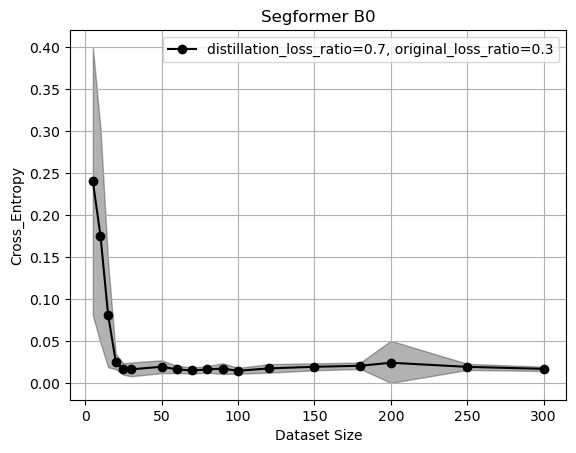

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()